In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
label1 = pd.read_csv('../data/preliminary_train_label_dataset.csv')
label2 = pd.read_csv('../data/preliminary_train_label_dataset_s.csv')
label_df = pd.concat([label1, label2]).reset_index(drop=True)
label_df = label_df.drop_duplicates().reset_index(drop=True)

In [3]:
submit_df = pd.read_csv('../data/preliminary_submit_dataset_b.csv')

In [4]:
log_df = pd.read_csv('./log_template.csv')

In [5]:
log_df['time'] = pd.to_datetime(log_df['time'])
label_df['fault_time'] = pd.to_datetime(label_df['fault_time'])
submit_df['fault_time'] = pd.to_datetime(submit_df['fault_time'])

log_df['time_ts'] = log_df["time"].values.astype(np.int64) // 10 ** 9
label_df['fault_time_ts'] = label_df["fault_time"].values.astype(np.int64) // 10 ** 9
submit_df['fault_time_ts'] = submit_df["fault_time"].values.astype(np.int64) // 10 ** 9

In [6]:
label_df = label_df.merge(log_df[['sn', 'server_model']].drop_duplicates(), on=['sn'], how='left')
submit_df = submit_df.merge(log_df[['sn', 'server_model']].drop_duplicates(), on=['sn'], how='left')

In [7]:
sentences = list()
for s in log_df['msg_lower'].values:
    sentences.append([w for w in s.split()])

In [8]:
w2v_model = Word2Vec(sentences, vector_size=64, window=3, min_count=2, sg=0, hs=1, seed=2022)

In [9]:
def get_w2v_mean(sentences):
    emb_matrix = list()
    vec = list()
    for w in sentences.split():
        if w in w2v_model.wv:
            vec.append(w2v_model.wv[w])
    if len(vec) > 0:
        emb_matrix.append(np.mean(vec, axis=0))
    else:
        emb_matrix.append([0] * w2v_model.vector_size)
    return emb_matrix

In [10]:
train_log_dfs = []
for idx in tqdm(range(label_df.shape[0])):
    row = label_df.iloc[idx]
    sn = row['sn']
    fault_time = row['fault_time']
    fault_time_ts = row['fault_time_ts']
    sub_log = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] <= fault_time_ts)]
    sub_log = sub_log.sort_values(by='time')

    df_tmp1 = sub_log[sub_log['time_ts'] - fault_time_ts >= -60 * 60 * 2]
    
    train_log_dfs.append(df_tmp1.iloc[:, 1:])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 16604/16604 [09:05<00:00, 30.46it/s]


In [11]:
label_df['log_df'] = train_log_dfs

In [12]:
test_log_dfs = []
for idx in tqdm(range(submit_df.shape[0])):
    row = submit_df.iloc[idx]
    sn = row['sn']
    fault_time = row['fault_time']
    fault_time_ts = row['fault_time_ts']
    sub_log = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] <= fault_time_ts)]
    sub_log = sub_log.sort_values(by='time')

    df_tmp1 = sub_log[sub_log['time_ts'] - fault_time_ts >= -60 * 60 * 2]
    
    test_log_dfs.append(df_tmp1.iloc[:, 1:])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3030/3030 [01:37<00:00, 30.98it/s]


In [13]:
submit_df['log_df'] = test_log_dfs

In [14]:
info_vec_map = {}

In [15]:
for info, group in label_df.groupby('server_model'):
    vecs = []
    for item in group['log_df']:
        vecs.append(get_w2v_mean('\n'.join(item['msg_lower'].values))[0])
    info_vec_map['%s'%(info)] = np.mean(vecs, axis=0) 

In [16]:
counters = [Counter(), Counter(), Counter(), Counter()]
for idx in tqdm(range(label_df.shape[0])):
    row = label_df.iloc[idx]
    sn = row['sn']
    fault_time = row['fault_time']
    fault_time_ts = row['fault_time_ts']
    label = row['label']
    
    sub_log = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] <= fault_time_ts)]
    sub_log = sub_log.sort_values(by='time')

    df_tmp = sub_log[sub_log['time_ts'] - fault_time_ts >= -60 * 60 * 2]
    counters[label].update(df_tmp['msg_lower'].values)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 16604/16604 [09:00<00:00, 30.72it/s]


In [17]:
vecs = []
for i in range(len(counters[0])):
    vec = get_w2v_mean(list(counters[0].keys())[i])
    weight = (list(counters[0].values())[i] / np.sum(list(counters[0].values())))
    vec = np.array(vec) * weight
    vecs.append(vec[0])
vec0 = np.sum(np.array(vecs), axis=0)

In [18]:
vecs = []
for i in range(len(counters[1])):
    vec = get_w2v_mean(list(counters[1].keys())[i])
    weight = (list(counters[1].values())[i] / np.sum(list(counters[1].values())))
    vec = np.array(vec) * weight
    vecs.append(vec[0])
vec1 = np.sum(np.array(vecs), axis=0)

In [19]:
vecs = []
for i in range(len(counters[2])):
    vec = get_w2v_mean(list(counters[2].keys())[i])
    weight = (list(counters[2].values())[i] / np.sum(list(counters[2].values())))
    vec = np.array(vec) * weight
    vecs.append(vec[0])
vec2 = np.sum(np.array(vecs), axis=0)

In [20]:
vecs = []
for i in range(len(counters[3])):
    vec = get_w2v_mean(list(counters[3].keys())[i])
    weight = (list(counters[3].values())[i] / np.sum(list(counters[3].values())))
    vec = np.array(vec) * weight
    vecs.append(vec[0])
vec3 = np.sum(np.array(vecs), axis=0)

In [14]:
label_df.groupby(['server_model', 'label']).size()

server_model  label
SM0           0          1
SM100         0         72
              1         29
              2         84
              3         14
                      ... 
SM98          2          3
SM99          0         12
              1         15
              2        173
              3          8
Length: 285, dtype: int64

In [14]:
tmp1 =  label_df[(label_df['server_model'] == 'SM100') & (label_df['label'] == 0)]

In [15]:
tmp2 = label_df[(label_df['server_model'] == 'SM100') & (label_df['label'] == 1)]

In [23]:
tmp1['log_df'].iloc[0]

,time,msg,server_model,msg_lower,msg_id,template_id,template,time_ts
390405,2020-03-19 20:02:30,Processor CPU_CATERR | | Asserted,SM100,processor cpu_caterr | | asserted,909,111,processor <:*:> <:*:> | | <:*:>,1584648150
390487,2020-03-19 20:02:31,Processor CPU_CATERR | | Asserted,SM100,processor cpu_caterr | | asserted,909,111,processor <:*:> <:*:> | | <:*:>,1584648151
390470,2020-03-19 20:02:32,Processor CPU_CATERR | | Asserted,SM100,processor cpu_caterr | | asserted,909,111,processor <:*:> <:*:> | | <:*:>,1584648152
390066,2020-03-19 20:02:33,Processor CPU_CATERR | | Asserted,SM100,processor cpu_caterr | | asserted,909,111,processor <:*:> <:*:> | | <:*:>,1584648153
390324,2020-03-19 20:02:34,Processor CPU_CATERR | | Asserted,SM100,processor cpu_caterr | | asserted,909,111,processor <:*:> <:*:> | | <:*:>,1584648154
...,...,...,...,...,...,...,...,...
397633,2020-03-19 20:04:23,Processor CPU_CATERR | Uncorrectable machine ...,SM100,processor cpu_caterr | uncorrectable machine c...,908,114,processor <:*:> <:*:> | uncorrectable machine ...,1584648263
407209,2020-03-19 20:04:24,System ACPI Power State #0x7d | S0/G0: workin...,SM100,system acpi power state #0x7d | s0/g0: working...,980,143,system <:*:> <:*:> <:*:> <:*:> | <:*:> <:*:> |...,1584648264
390573,2020-03-19 20:04:24,Processor CPU_CATERR | | Asserted,SM100,processor cpu_caterr | | asserted,909,111,processor <:*:> <:*:> | | <:*:>,1584648264
398092,2020-03-19 20:04:24,Processor CPU_CATERR | Uncorrectable machine ...,SM100,processor cpu_caterr | uncorrectable machine c...,908,114,processor <:*:> <:*:> | uncorrectable machine ...,1584648264


In [24]:
tmp2['log_df'].iloc[2]

,time,msg,server_model,msg_lower,msg_id,template_id,template,time_ts
390086,2020-07-15 14:08:20,Processor CPU_CATERR | | Asserted,SM100,processor cpu_caterr | | asserted,909,111,processor <:*:> <:*:> | | <:*:>,1594822100
390308,2020-07-15 14:08:21,Processor CPU_CATERR | | Asserted,SM100,processor cpu_caterr | | asserted,909,111,processor <:*:> <:*:> | | <:*:>,1594822101
390283,2020-07-15 14:08:22,Processor CPU_CATERR | | Asserted,SM100,processor cpu_caterr | | asserted,909,111,processor <:*:> <:*:> | | <:*:>,1594822102
390322,2020-07-15 14:08:23,Processor CPU_CATERR | | Asserted,SM100,processor cpu_caterr | | asserted,909,111,processor <:*:> <:*:> | | <:*:>,1594822103
390284,2020-07-15 14:08:24,Processor CPU_CATERR | | Asserted,SM100,processor cpu_caterr | | asserted,909,111,processor <:*:> <:*:> | | <:*:>,1594822104
...,...,...,...,...,...,...,...,...
390562,2020-07-15 14:10:00,Processor CPU_CATERR | | Asserted,SM100,processor cpu_caterr | | asserted,909,111,processor <:*:> <:*:> | | <:*:>,1594822200
397372,2020-07-15 14:10:01,Processor CPU_CATERR | Uncorrectable machine ...,SM100,processor cpu_caterr | uncorrectable machine c...,908,114,processor <:*:> <:*:> | uncorrectable machine ...,1594822201
407140,2020-07-15 14:10:01,System ACPI Power State #0x7d | S0/G0: workin...,SM100,system acpi power state #0x7d | s0/g0: working...,980,143,system <:*:> <:*:> <:*:> <:*:> | <:*:> <:*:> |...,1594822201
390112,2020-07-15 14:10:01,Processor CPU_CATERR | | Asserted,SM100,processor cpu_caterr | | asserted,909,111,processor <:*:> <:*:> | | <:*:>,1594822201


In [116]:
for i in range(20):
    if tmp1['log_df'].iloc[i]['time_ts'].values.shape[0] > 0:
        print(tmp1['log_df'].iloc[i]['time_ts'].values[-1] - tmp1['log_df'].iloc[i]['time_ts'].values[0])

2259
1732
475
4286
458
939
4203
568
4253
4116
956
4224
440
2714
624
432
475


In [114]:
for i in range(10):
    print(tmp2['log_df'].iloc[i]['time_ts'].values[-1] - tmp2['log_df'].iloc[i]['time_ts'].values[0])

502
2244
2382
683
472
571
1573
472
467
2022


In [21]:
def make_dataset(dataset, data_type='train'):
    ret = []
    for idx in tqdm(range(dataset.shape[0])):
        row = dataset.iloc[idx]
        sn = row['sn']
        fault_time = row['fault_time']
        fault_time_ts = row['fault_time_ts']
        sub_log = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] <= fault_time_ts)]
        sub_log = sub_log.sort_values(by='time')

        df_tmp1 = sub_log[sub_log['time_ts'] - fault_time_ts >= -60 * 60 * 2]
        
        data = {
            'sn': sn,
            'fault_time': fault_time,
        }
        vec = get_w2v_mean('\n'.join(df_tmp1['msg_lower'].values.astype(str)))[0]
        data['cos_sim_label0'] = cosine_similarity([vec], [vec0])[0][0]
        data['cos_sim_label1'] = cosine_similarity([vec], [vec1])[0][0]
        data['cos_sim_label2'] = cosine_similarity([vec], [vec2])[0][0]
        data['cos_sim_label3'] = cosine_similarity([vec], [vec3])[0][0]
        
        data['cos_sim_server_model'] = cosine_similarity([vec], [info_vec_map[row['server_model']]])[0][0]
        
#         across_vec = np.multiply(curr_vec, count_shop_embed_map[shop_id])
#         cs = cosine_similarity([curr_vec], [count_shop_embed_map[shop_id]])[0][0]
#         dist = np.linalg.norm(curr_vec - count_shop_embed_map[shop_id])
#         p = np.corrcoef(curr_vec, count_shop_embed_map[shop_id])[0][1]
        
        if data_type == 'train':
            data['label'] = row['label']
        ret.append(data)
    return ret

In [22]:
train = make_dataset(label_df, data_type='train')
df_train = pd.DataFrame(train)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 16604/16604 [09:29<00:00, 29.13it/s]


In [23]:
test = make_dataset(submit_df, data_type='test')
df_test = pd.DataFrame(test)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3030/3030 [01:42<00:00, 29.64it/s]


In [24]:
df_train.to_csv('train_helper.csv', index=False)
df_test.to_csv('test_helper.csv', index=False)

In [11]:
# train_log_df = pd.read_csv('../data/preliminary_sel_log_dataset.csv')
# test_log_df = pd.read_csv('../data/preliminary_sel_log_dataset_a.csv')

In [21]:
# train_log_df['time'] = pd.to_datetime(train_log_df['time'])
# test_log_df['time'] = pd.to_datetime(test_log_df['time'])

In [22]:
# for sn, group in test_log_df.groupby('sn'):
#     group = group.sort_values(by='time')
#     print(group.iloc[-1]['time'] - group.iloc[0]['time'])

0 days 04:07:43
0 days 00:14:27
0 days 00:00:00
0 days 00:41:17
0 days 00:09:23
0 days 00:00:00
0 days 00:00:18
0 days 00:01:50
0 days 00:00:00
0 days 00:00:00
0 days 00:18:43
0 days 00:00:27
0 days 00:00:02
0 days 00:00:06
0 days 22:51:27
0 days 00:01:50
0 days 00:00:12
0 days 00:00:00
0 days 00:03:59
0 days 00:00:01
0 days 02:39:10
0 days 00:00:00
0 days 00:01:31
0 days 00:00:00
0 days 00:00:47
0 days 00:00:00
0 days 00:00:00
0 days 00:12:11
0 days 00:06:51
0 days 00:04:35
0 days 00:23:06
0 days 00:02:13
87 days 12:14:22
0 days 00:08:55
0 days 00:08:30
0 days 00:01:52
0 days 00:01:49
0 days 00:00:00
0 days 00:16:24
0 days 00:03:40
0 days 00:00:02
0 days 00:00:00
0 days 00:00:39
0 days 12:21:17
0 days 00:02:17
0 days 01:19:43
0 days 00:09:08
0 days 00:00:08
0 days 00:00:00
0 days 00:00:00
27 days 16:58:56
0 days 00:00:02
0 days 00:03:42
0 days 00:05:25
0 days 00:00:03
0 days 07:39:38
0 days 00:00:00
0 days 00:00:00
0 days 07:36:06
0 days 00:00:03
0 days 00:53:25
0 days 00:00:00
0 days

0 days 00:00:16
0 days 00:31:03
0 days 00:17:07
0 days 00:10:20
0 days 00:00:01
0 days 00:38:12
0 days 00:02:49
0 days 00:17:37
43 days 10:11:13
0 days 00:01:52
90 days 00:57:34
0 days 00:00:00
0 days 00:00:00
0 days 00:00:31
0 days 00:00:00
0 days 00:54:49
0 days 00:00:00
0 days 00:00:00
0 days 00:00:00
0 days 00:02:27
0 days 00:00:00
0 days 00:00:00
0 days 00:02:37
0 days 00:02:08
0 days 00:03:28
0 days 00:12:18
115 days 08:30:58
0 days 00:13:09
0 days 00:00:00
0 days 00:19:14
0 days 16:56:30
0 days 00:02:59
0 days 00:00:00
0 days 00:02:53
0 days 00:02:29
0 days 00:00:00
0 days 05:52:51
0 days 00:00:00
0 days 00:00:00
0 days 00:06:24
0 days 00:56:30
0 days 00:03:16
0 days 00:01:01
0 days 00:00:00
0 days 00:12:47
0 days 14:30:23
0 days 00:00:00
0 days 00:34:48
0 days 00:00:00
0 days 00:00:00
0 days 00:00:00
0 days 00:44:44
0 days 00:01:57
0 days 00:06:30
0 days 00:02:28
0 days 00:00:03
0 days 00:12:39
0 days 00:00:00
0 days 00:57:21
0 days 02:31:00
0 days 07:36:05
0 days 00:00:00
0 da

0 days 00:55:43
0 days 00:00:00
35 days 15:59:19
0 days 00:00:00
0 days 00:41:41
0 days 00:00:17
0 days 00:00:00
0 days 00:00:00
0 days 00:00:00
0 days 00:00:00
0 days 00:00:00
0 days 00:02:16
0 days 00:00:00
0 days 00:00:00
0 days 00:00:26
0 days 00:00:00
0 days 00:03:34
0 days 01:27:12
0 days 00:00:00
0 days 00:00:07
0 days 00:22:21
0 days 00:02:38
0 days 00:00:11
0 days 00:02:53
0 days 00:00:00
0 days 00:00:16
0 days 00:00:02
0 days 00:00:00
0 days 02:51:30
0 days 00:00:00
0 days 00:00:00
0 days 00:00:00
0 days 00:00:00
0 days 00:39:10
0 days 00:09:15
0 days 00:42:48
0 days 00:00:00
0 days 00:00:00
0 days 00:00:00
0 days 00:02:53
0 days 00:00:00
0 days 00:07:57
0 days 00:04:09
0 days 00:05:32
0 days 00:45:59
0 days 00:09:53
0 days 00:06:39
0 days 00:10:09
0 days 00:00:00
0 days 00:11:42
0 days 00:01:37
0 days 00:02:43
0 days 00:00:12
0 days 00:06:27
0 days 00:28:09
0 days 00:01:51
0 days 00:02:02
0 days 00:25:08
0 days 00:01:14
0 days 00:00:00
0 days 00:00:00
0 days 00:22:27
0 days 

0 days 10:44:37
0 days 00:00:00
0 days 00:06:19
0 days 05:56:01
0 days 00:00:00
0 days 00:03:55
0 days 00:06:28
0 days 00:01:07
0 days 00:00:00
0 days 00:03:36
0 days 00:00:00
0 days 00:01:44
0 days 00:00:00
0 days 01:11:28
0 days 00:00:00
0 days 00:09:04
0 days 00:00:00
0 days 00:00:00
0 days 00:02:01
0 days 00:00:00
0 days 00:00:33
0 days 00:03:47
0 days 00:00:00
0 days 00:00:00
0 days 00:00:00
0 days 00:00:00
0 days 06:35:40
0 days 00:00:00
0 days 00:00:00
0 days 00:25:02
0 days 07:11:42
0 days 00:09:49
0 days 00:19:19
13 days 09:22:22
0 days 00:01:46
0 days 00:00:00
0 days 00:12:49
0 days 00:03:07
0 days 00:00:16
70 days 14:28:49
0 days 00:21:45
0 days 00:22:30
0 days 00:00:00
0 days 00:02:18
0 days 00:00:01
0 days 00:00:40
0 days 00:00:07
0 days 00:05:26
0 days 00:00:03
0 days 00:29:33
0 days 00:00:10
0 days 00:09:59
117 days 09:50:58
0 days 00:00:44
0 days 00:01:37
0 days 00:00:00
0 days 00:00:05
0 days 00:00:05
0 days 00:00:00
0 days 00:00:00
0 days 00:02:37
0 days 00:02:06
0 da

54 days 16:18:26
0 days 00:00:00
0 days 00:00:52
0 days 00:06:28
0 days 00:00:04
0 days 00:31:40
0 days 00:45:20


In [25]:
counter0 = Counter()
for idx in tqdm(range(label_df.shape[0])):
    row = label_df.iloc[idx]
    sn = row['sn']
    fault_time = row['fault_time']
    fault_time_ts = row['fault_time_ts']
    label = row['label']
    
    if not label == 0:
        continue

    sub_log = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] <= fault_time_ts)]
    sub_log = sub_log.sort_values(by='time')

    df_tmp = sub_log[sub_log['time_ts'] - fault_time_ts >= -60 * 60 * 2]
    counter0.update(df_tmp['msg_lower'].values)
#     processor_df = df_tmp[df_tmp['msg_lower'].str.startswith('button')]
#     processor_cnt.append(processor_df.shape[0])
#     processor_percent.append(processor_df.shape[0] / df_tmp.shape[0] if df_tmp.shape[0] > 0 else -1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16604/16604 [00:48<00:00, 339.71it/s]


In [26]:
counter1 = Counter()
for idx in tqdm(range(label_df.shape[0])):
    row = label_df.iloc[idx]
    sn = row['sn']
    fault_time = row['fault_time']
    fault_time_ts = row['fault_time_ts']
    label = row['label']
    
    if not label == 1:
        continue

    sub_log = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] <= fault_time_ts)]
    sub_log = sub_log.sort_values(by='time')

    df_tmp = sub_log[sub_log['time_ts'] - fault_time_ts >= -60 * 60 * 2]
    processor_df = df_tmp[df_tmp['msg_lower'].str.startswith('button')]
    counter1.update(df_tmp['msg_lower'].values)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16604/16604 [01:49<00:00, 151.94it/s]


In [43]:
counter0.most_common()[:100]

[('memory hex | correctable ecc | asserted', 2621),
 ('system event #0xff | timestamp clock sync | asserted', 1884),
 ('memory cpu0b0_dimm_stat | correctable ecc | asserted', 1478),
 ('memory cpu1b0_dimm_stat | correctable ecc | asserted', 1386),
 ('processor cpu1_status | configuration error | asserted', 1209),
 ('processor cpu0_status | configuration error | asserted', 1040),
 ('system boot initiated bios_boot_up | initiated by warm reset | asserted',
  991),
 ('processor cpu_caterr | uncorrectable machine check exception | asserted',
  975),
 ('memory cpu0a0_dimm_stat | correctable ecc | asserted', 956),
 ('system boot initiated | initiated by power up | asserted', 936),
 ('processor hex | configuration error | asserted', 870),
 ('unknown cpu0 caterr |  | asserted', 713),
 ('unknown cpu0 mcerr |  | asserted', 711),
 ('system boot initiated bios_boot_up | initiated by power up | asserted',
  709),
 ('system acpi power state acpi_pwr_status | s0/g0: working | asserted', 698),
 ('syste

In [44]:
counter1.most_common()[:100]

[('memory hex | correctable ecc | asserted', 6241),
 ('system event #0xff | timestamp clock sync | asserted', 3914),
 ('system boot initiated bios_boot_up | initiated by warm reset | asserted',
  2596),
 ('system boot initiated | initiated by power up | asserted', 2330),
 ('processor cpu1_status | configuration error | asserted', 2313),
 ('memory cpu1e0_dimm_stat | correctable ecc | asserted', 2184),
 ('system boot initiated bios_boot_up | initiated by power up | asserted',
  2112),
 ('memory cpu1a0_dimm_stat | correctable ecc | asserted', 2001),
 ('system acpi power state acpi_pwr_status | s0/g0: working | asserted', 1834),
 ('system acpi power state acpi_pwr_status | s4/s5: soft-off | asserted',
  1710),
 ('memory cpu1d0_dimm_stat | correctable ecc | asserted', 1553),
 ('processor hex | configuration error | asserted', 1552),
 ('unknown cpu0 mcerr |  | asserted', 1538),
 ('unknown cpu0 caterr |  | asserted', 1523),
 ('watchdog2 ipmi watchdog | power cycle | asserted', 1427),
 ('micro

In [37]:
counter0['processor cpu0_status | uncorrectable machine check exception | deasserted'] /\
np.sum(list(counter0.values()))

0.00508486067481751

In [40]:
counter1['processor cpu0_status | uncorrectable machine check exception | deasserted'] /\
np.sum(list(counter1.values()))

0.013587208916605852

In [11]:
import seaborn as sns

/data/projects/log-based-failuer-diagnosis/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/projects/log-based-failuer-diagnosis/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

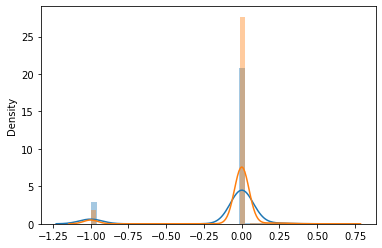

In [20]:
sns.distplot(processor_percent)
sns.distplot(processor_percent1)

In [6]:
log_df['time_gap'] = log_df['time'].dt.ceil('2h')

In [18]:
msgids_list = list()
for info, group in log_df.groupby(['sn', 'time_gap']):
    group = group.sort_values(by='time')
    msgids_list.append(np.unique(group['msg_id'].values))

In [19]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(msgids_list).transform(msgids_list)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [20]:
from mlxtend.frequent_patterns import fpgrowth

fpgrowth(df, min_support=0.01)

,support,itemsets
0,0.112313,(228)
1,0.144064,(230)
2,0.014417,(509)
3,0.014383,(195)
4,0.171065,(15)
...,...,...
455,0.010041,"(717, 725, 718, 727)"
456,0.010041,"(717, 721, 725, 718)"
457,0.010041,"(721, 725, 718, 727)"
458,0.010041,"(717, 721, 725, 727)"
